Using device: cpu

🚀 Training VGG on CIFAR-10...
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:10<00:00, 51.1MB/s]


VGG Epoch 1/5 - Train Acc: 18.75%, Val Acc: 31.00%
VGG Epoch 2/5 - Train Acc: 50.25%, Val Acc: 46.00%
VGG Epoch 3/5 - Train Acc: 65.25%, Val Acc: 52.00%
VGG Epoch 4/5 - Train Acc: 76.50%, Val Acc: 55.00%
VGG Epoch 5/5 - Train Acc: 91.50%, Val Acc: 53.00%

🚀 Training RESNET on CIFAR-10...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 84.9MB/s]


RESNET Epoch 1/5 - Train Acc: 26.50%, Val Acc: 32.00%
RESNET Epoch 2/5 - Train Acc: 88.75%, Val Acc: 47.00%
RESNET Epoch 3/5 - Train Acc: 98.25%, Val Acc: 56.00%
RESNET Epoch 4/5 - Train Acc: 100.00%, Val Acc: 64.00%
RESNET Epoch 5/5 - Train Acc: 100.00%, Val Acc: 65.00%

🚀 Training GOOGLENET on CIFAR-10...
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 84.9MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


GOOGLENET Epoch 1/5 - Train Acc: 14.50%, Val Acc: 28.00%
GOOGLENET Epoch 2/5 - Train Acc: 63.75%, Val Acc: 45.00%
GOOGLENET Epoch 3/5 - Train Acc: 79.00%, Val Acc: 55.00%
GOOGLENET Epoch 4/5 - Train Acc: 88.50%, Val Acc: 60.00%
GOOGLENET Epoch 5/5 - Train Acc: 91.75%, Val Acc: 61.00%


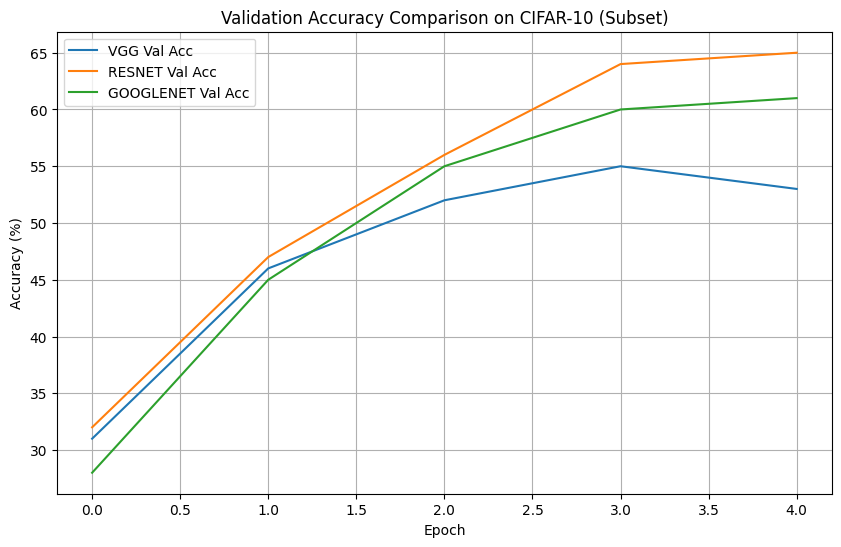


❗ Image not found: download.jpeg. Please add an image to test.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
from PIL import Image
import os

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# CIFAR-10 classes
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# Transform for resizing to ImageNet input size
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 (subset for quick run)
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

dataset = Subset(dataset, range(500))  # only first 500 samples for speed

# Split into train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Training function
def train_and_evaluate(model, name, num_epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        correct, total = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # handle GoogLeNet aux outputs
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_accs.append(100 * correct / total)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_accs.append(100 * correct / total)

        print(f"{name} Epoch {epoch+1}/{num_epochs} - Train Acc: {train_accs[-1]:.2f}%, Val Acc: {val_accs[-1]:.2f}%")

    return model, train_accs, val_accs

# Model loader
def get_model(name):
    if name == "vgg":
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        model.classifier[6] = nn.Linear(4096, 10)
    elif name == "resnet":
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif name == "googlenet":
        model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1, aux_logits=True)
        model.fc = nn.Linear(model.fc.in_features, 10)
    else:
        raise ValueError("Unknown model")
    return model

# Train all models
results = {}
trained_models = {}

for model_name in ["vgg", "resnet", "googlenet"]:
    print(f"\n🚀 Training {model_name.upper()} on CIFAR-10...")
    model = get_model(model_name)
    trained_model, train_acc, val_acc = train_and_evaluate(model, model_name.upper(), num_epochs=5)
    results[model_name] = (train_acc, val_acc)
    trained_models[model_name] = trained_model

# Plot validation accuracy
plt.figure(figsize=(10, 6))
for name, (train_acc, val_acc) in results.items():
    plt.plot(val_acc, label=f'{name.upper()} Val Acc')
plt.title('Validation Accuracy Comparison on CIFAR-10 (Subset)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Prediction function
def predict_image(image_path, models_dict):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    print(f"\n🔍 Prediction results for image: {image_path}")
    for model_name, model in models_dict.items():
        model.eval()
        with torch.no_grad():
            outputs = model(image)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, predicted = outputs.max(1)
            pred_class = class_names[predicted.item()]
            print(f"{model_name.upper():<10} => {pred_class}")

# Test with custom image
custom_image_path = "download.jpeg"
if os.path.exists(custom_image_path):
    predict_image(custom_image_path, trained_models)
else:
    print(f"\n❗ Image not found: {custom_image_path}. Please add an image to test.")
